# Getting started with Task 4

Download the dataset from the [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106) using the script `download_intracardiac_dataset.sh`:

```bash
source download_intracardiac_dataset.sh
```

In [ ]:
%%shell
#!/bin/bash

# Download all the components of the dataset from https://library.ucsd.edu/dc/object/bb29449106
# and put them in the directory intracardiac_dataset

# Make the directory
echo "Making directory intracardiac_dataset"
mkdir -p intracardiac_dataset
echo "Done"

# Move into the directory
cd intracardiac_dataset

# Download the first element (README.md)
echo "Downloading the dataset - This may take a while"
wget https://library.ucsd.edu/dc/object/bb29449106/_1_1.md/download -O README.md
for i in {2..22}
do
    wget https://library.ucsd.edu/dc/object/bb29449106/_${i}_1.tgz/download
    echo "Unzipping the file"
    tar -xvzf download
    rm -f download
done
echo "Done"

# Return to the parent directory
cd -

Streaming output truncated to the last 5000 lines.
data_hearts_dd_0p2_geo_inn_act_2_bcl_I/VmData_hearts_dd_0p2_geo_inn_act_2_bcl_I_bcl.1000.innerindex.4.volunteer.v1.npy
data_hearts_dd_0p2_geo_inn_act_2_bcl_I/pECGData_hearts_dd_0p2_geo_inn_act_2_bcl_I_bcl.600.innerindex.60.volunteer.v6.npy
data_hearts_dd_0p2_geo_inn_act_2_bcl_I/VmData_hearts_dd_0p2_geo_inn_act_2_bcl_I_bcl.600.innerindex.16.volunteer.v1.npy
data_hearts_dd_0p2_geo_inn_act_2_bcl_I/pECGData_hearts_dd_0p2_geo_inn_act_2_bcl_I_bcl.600.innerindex.8.volunteer.v9.npy
data_hearts_dd_0p2_geo_inn_act_2_bcl_I/pECGData_hearts_dd_0p2_geo_inn_act_2_bcl_I_bcl.600.innerindex.16.volunteer.v12.npy
data_hearts_dd_0p2_geo_inn_act_2_bcl_I/VmData_hearts_dd_0p2_geo_inn_act_2_bcl_I_bcl.1000.innerindex.26.volunteer.v9.npy
data_hearts_dd_0p2_geo_inn_act_2_bcl_I/VmData_hearts_dd_0p2_geo_inn_act_2_bcl_I_bcl.600.innerindex.15.volunteer.v2.npy
data_hearts_dd_0p2_geo_inn_act_2_bcl_I/pECGData_hearts_dd_0p2_geo_inn_act_2_bcl_I_bcl.1000.innerindex.10.volu

## Load Modules and Preprocessing Functions

Load modules and preprocessing functions.

In [ ]:
import glob, re, os
import numpy as np
import matplotlib.pyplot as plt
from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import TransformerEncoder, TransformerEncoderLayer

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from torch.utils.data import TensorDataset, DataLoader

from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/LLNL_Task3')

Mounted at /content/drive


Load the `cardiac_ml_tools` module.

In [ ]:
%run /content/drive/MyDrive/LLNL/cardiac_ml_tools.py

## Load the dataset

In [ ]:
data_dirs = []
regex = r'data_hearts_dd_0p2*'
DIR='/content/intracardiac_dataset/' # This should be the path to the intracardiac_dataset, it can be downloaded using data_science_challenge_2023/download_intracardiac_dataset.sh
for x in os.listdir(DIR):
    if re.match(regex, x):
        data_dirs.append(DIR + x)
file_pairs = read_data_dirs(data_dirs)
print('Number of file pairs: {}'.format(len(file_pairs)))
# example of file pair
print("Example of file pair:")
print("{}\n{}".format(file_pairs[0][0], file_pairs[0][1]))


Number of file pairs: 16117
Example of file pair:
/content/intracardiac_dataset/data_hearts_dd_0p2_geo_act_3_bcl/pECGData_hearts_dd_0p2_geo_act_3_bcl_bcl.1000.pattern.0.volunteer.v1.npy
/content/intracardiac_dataset/data_hearts_dd_0p2_geo_act_3_bcl/VmData_hearts_dd_0p2_geo_act_3_bcl_bcl.1000.pattern.0.volunteer.v1.npy


## Dataset details

The dataset [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106)
consists of pairs of computationally simulated intracardiac transmembrane voltage recordings and ECG signals.
In total, 16140 organ-level simulations were conducted to create this dataset.
Simulations were performed using Lassen supercomputer at Lawrence Livermore National Lab (LLNL), concurrently utilizing 4 GPUs and 40 CPU cores.
Each simulation produced pairs of 500ms-by-10 raw electrode signals and 500ms-by-75 transmembrane voltage signals.
For convenience, we collect those signals in matrices and give them the following names:

Tensor | Description | Shape | Notes
--- | --- | --- | ---
$X$ | Row electrode signals | $10 \times 500$ | 10-lead ECG signals from the simulated torso (in [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106))
$V$ | Activation map | $75 \times 500$ | Transmembrane voltage signals from the simulated heart (in [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106))
$E$ | 12-lead ECG signals | $12 \times 500$ | 12-lead ECG signals obtained by `get_standard_leads`($X$)
$A$ | Activation map | $75 \times 1$ | Activation time, defined as $A_i = \text{min}_j(V_{ij})$

**IMPORTANT** : The raw data in the dataset consists of 10-lead ECG signals and 75-lead transmembrane voltage signals. The 12-lead ECG signals are obtained from the 10-lead ECG signals using the function `get_standard_leads` (in the file `cardiac_ml_tools.py`).

The overall generation process is shown in the following image. The ECG signal is recorded using 10 virtual electrodes and the transmembrane voltages are recorded at 75 points within the myocardium. The transmembrane voltages are then used to generate the spatio-temporal activation maps.

![ECG 10 2 12](https://github.com/landajuela/cardiac_challenge/blob/main/figures/data_generation.png?raw=1)

## Getting the standard 12-lead ECG from the 10-lead ECG

The function `get_standard_leads` (in the file `cardiac_ml_tools.py`) is used to obtain the 12-lead ECG signals from the 10-lead ECG signals. It implements the following transformation, where the (Wilson Lead) is defined as $Vw = 1/3*(RA + LA + LL)$:
$$
\left\{
\begin{array}{lll}
    X_{:,1}  & \to  & RA \\
    X_{:,2}  & \to  & LA \\
    X_{:,3}  & \to  & LL \\
    X_{:,4}  & \to  & RL \\
    X_{:,5}  & \to  & V1 \\
    X_{:,6}  & \to  & V2 \\
    X_{:,7}  & \to  & V3 \\
    X_{:,8}  & \to  & V4 \\
    X_{:,9}  & \to  & V5 \\
    X_{:,10} & \to &  V6 \\
\end{array}
\right.
\text{        and        }
\left\{
\begin{array}{lll}          
\text{Lead } I& : & LA - RA \\
\text{Lead } II& : & LL - RA \\
\text{Lead } III& : & LL - LA \\
\text{Lead } aVR& : &  \frac{3}{2} (RA - Vw) \\
\text{Lead } aVL& : &  \frac{3}{2} (LA - Vw) \\
\text{Lead } aVF& : &  \frac{3}{2} (LL - Vw)\\
\text{Lead } V1 & : & V1 - Vw \\
\text{Lead } V2 & : & V2 - Vw \\
\text{Lead } V3 & : & V3 - Vw \\
\text{Lead } V4 & : & V4 - Vw \\
\text{Lead } V5 & : & V5 - Vw \\
\text{Lead } V6 & : & V6 - Vw \\
\end{array}
\right.
$$


Case 213 : /content/intracardiac_dataset/data_hearts_dd_0p2_geo_act_3_bcl/pECGData_hearts_dd_0p2_geo_act_3_bcl_bcl.1000.pattern.21.volunteer.v12.npy


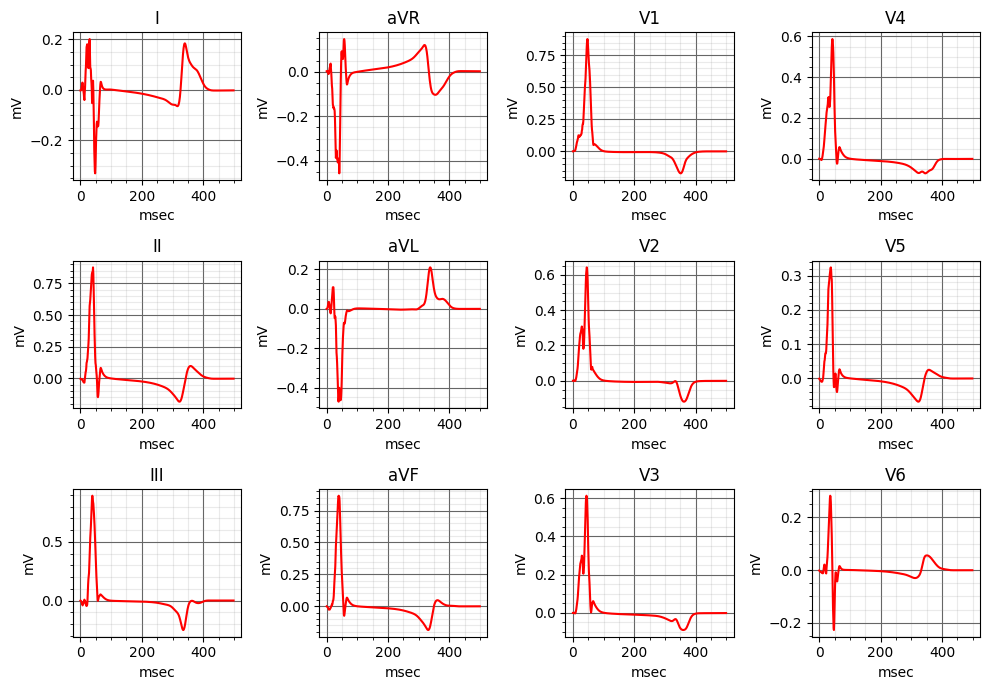

In [ ]:
# Example of file pair
case = 213
# ECG plot
row = 3
column = 4
num_timesteps = 500
plt.figure(figsize=(10, 7))
titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
reorder = {1:1,2:5,3:9,4:2,5:6,6:10,7:3,8:7,9:11,10:4,11:8,12:12} # reorder the leads to standard 12-lead ECG display

print('Case {} : {}'.format(case, file_pairs[case][0]))
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)

# create a figure with 12 subplots
for i in range(pECGData.shape[1]):
    plt.subplot(row, column, reorder[i + 1])
    plt.plot(pECGData[0:num_timesteps,i],'r')
    plt.title(titles[i])
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    plt.xlabel('msec')
    plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()

## Getting the transmembrane voltages

Case 213 : /content/intracardiac_dataset/data_hearts_dd_0p2_geo_act_3_bcl/pECGData_hearts_dd_0p2_geo_act_3_bcl_bcl.1000.pattern.21.volunteer.v12.npy
(500, 75)


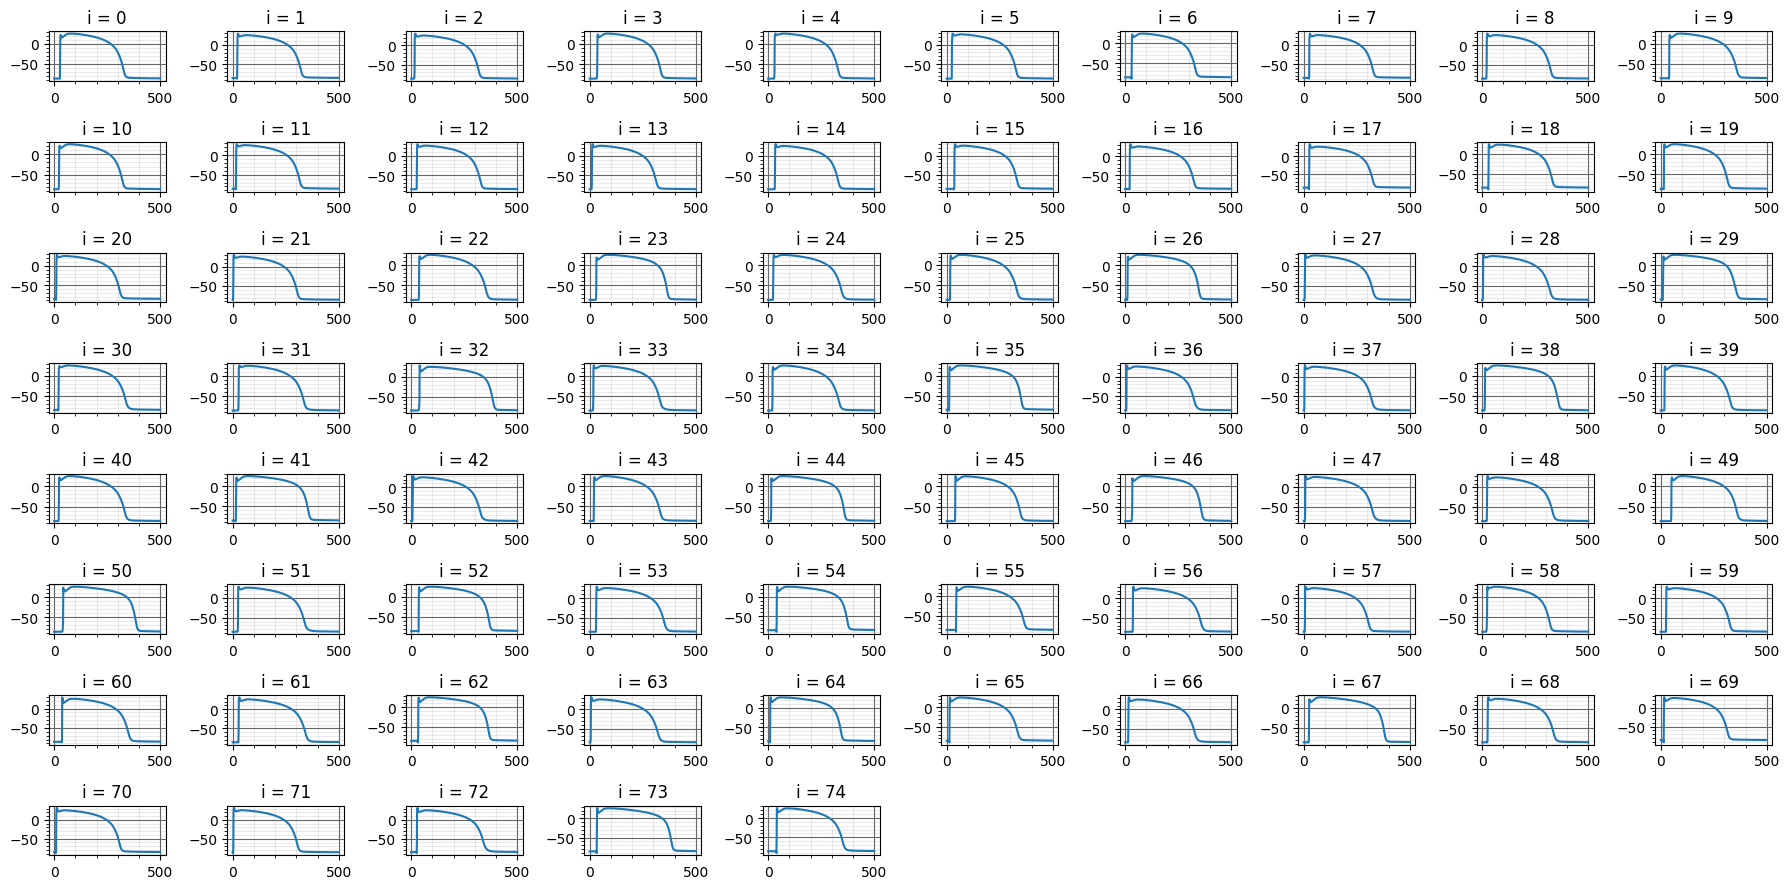

In [ ]:
# Example of file pair
case = 213
# Vm plot
row = 7
column = 10
plt.figure(figsize=(18, 9))

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])

print(VmData.shape)

for count, i in enumerate(range(VmData.shape[1])):
    plt.subplot(8, 10, count + 1)
    plt.plot(VmData[0:num_timesteps,i])
    plt.title(f'i = {i}')
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    # plt.xlabel('msec')
    # plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()


## Task 4: Learning the mapping from the 12-lead ECG to the 75 transmembrane voltages

Case 213 : /content/intracardiac_dataset/data_hearts_dd_0p2_geo_act_3_bcl/pECGData_hearts_dd_0p2_geo_act_3_bcl_bcl.1000.pattern.21.volunteer.v12.npy
Case 213 : /content/intracardiac_dataset/data_hearts_dd_0p2_geo_act_3_bcl/pECGData_hearts_dd_0p2_geo_act_3_bcl_bcl.1000.pattern.21.volunteer.v12.npy


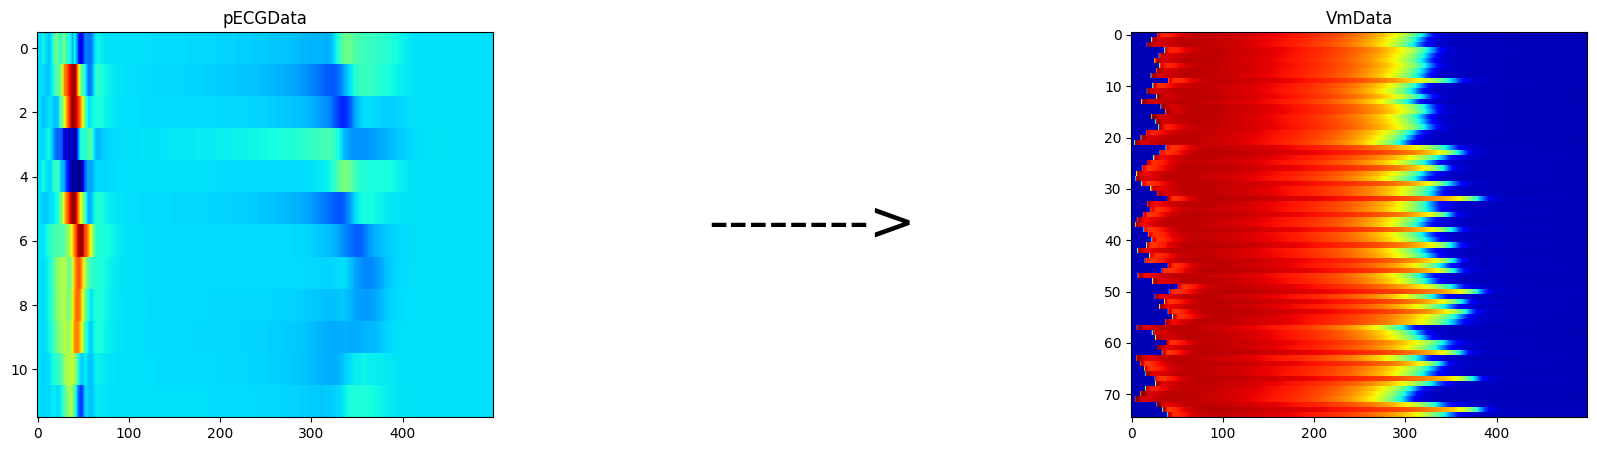

In [ ]:
# make a plot with the "pECGData" -> "ActTime"
case = 213

print('Case {} : {}'.format(case, file_pairs[case][0]))
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])

# plot in row the tensors pECGData and ActTime with an arrow pointing to the activation time
row = 1
column = 3
plt.figure(figsize=(20, 5))
plt.subplot(row, column, 1)
# plot pECGData transposed
plt.imshow(pECGData.T, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('pECGData')
plt.subplot(row, column, 2)
# print a text "->"
plt.text(0.5, 0.5, '-------->', fontsize=40, horizontalalignment='center', verticalalignment='center')
plt.axis('off')
plt.subplot(row, column, 3)
# plot Vm transposed
plt.imshow(VmData.T, cmap='jet', interpolation='nearest', aspect='auto')
# not xticks
# plt.xticks([])
plt.title('VmData')
plt.show()
plt.close()

# Tricks

- As in many machine learning problems, normalization of the data might be helpful or even necessary. Different normalization schemes might be applied.

In [ ]:
# Goal: pECGData to VmData

'''
How to extract value from a case
case = 213

print('Case {} : {}'.format(case, file_pairs[case][0]))
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])
'''

print("VmData: ", VmData.shape)
print("pECGData: ", pECGData.shape)

VmData:  (500, 75)
pECGData:  (500, 12)


In [ ]:
# concat the data into one place

# To choose which cases should be for testing and which should be for training
num_of_peps = 5000 #len(file_pairs)
Data_points = np.linspace(0, num_of_peps - 1, num = num_of_peps, dtype = int)
train_indx, test_indx = train_test_split(Data_points, test_size=0.1, random_state=43)

vmdata = []
standard_leads = []

for case in range(num_of_peps):
    pECGData = np.load(file_pairs[case][0])
    pECGData = get_standard_leads(pECGData)
    standard_leads.append(pECGData.T)
    VmData = np.load(file_pairs[case][1])
    vmdata.append(VmData)

vmdata = torch.tensor(np.array(vmdata))
standard_leads = torch.tensor(np.array(standard_leads))

# get the data
y_train = vmdata[train_indx,:,:]
y_test = vmdata[test_indx,:,:]
X_train = standard_leads[train_indx,:,:]
X_test = standard_leads[test_indx,:,:]

In [ ]:
# normalize tensors
# Find the minimum and maximum values across the tensors
min_value = torch.min(torch.min(y_train), torch.min(y_test))
max_value = torch.max(torch.max(y_train), torch.max(y_test))

# Convert the tensors to Python scalars
min_value = min_value.item()
max_value = max_value.item()

normalized_y_train = (y_train - min_value) / (max_value-min_value)  # (tensor - min) / range

normalized_y_test = (y_test - min_value) / (max_value-min_value)

## print shapes
print("train shape: ", X_train.shape, normalized_y_train.shape)
print("test shape: ", X_test.shape, normalized_y_test.shape)

train shape:  torch.Size([4500, 12, 500]) torch.Size([4500, 500, 75])
test shape:  torch.Size([500, 12, 500]) torch.Size([500, 500, 75])


In [ ]:
## Create dataloader
train_dataset = TensorDataset(X_train, normalized_y_train.permute(0,2,1))
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

data_iter = iter(train_dataloader) # create iterator of dataloader to check if data is ok
first_batch = next(data_iter)

data_shape = first_batch[0].shape
labels_shape = first_batch[1].shape

print("Data shape:", data_shape)
print("Labels shape:", labels_shape)

Data shape: torch.Size([32, 12, 500])
Labels shape: torch.Size([32, 75, 500])


In [ ]:
## network

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv1d(in_channels=12, out_channels=64, kernel_size=25, padding = 12)
        self.bn1 = nn.BatchNorm1d(64)  # Batch Normalization after conv1
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=15, padding = 7)
        self.bn2 = nn.BatchNorm1d(128)  # Batch Normalization after conv2
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=9, padding = 4)
        self.bn3 = nn.BatchNorm1d(256)  # Batch Normalization after conv3
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding = 1)
        self.bn4 = nn.BatchNorm1d(512)  # Batch Normalization after conv4

        self.conv5 = nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=3, padding = 1)
        self.bn5 = nn.BatchNorm1d(1024)  # Batch Normalization after conv4
        self.conv6 = nn.Conv1d(in_channels=1024, out_channels=1024, kernel_size=15, padding = 7)
        self.bn6 = nn.BatchNorm1d(1024)  # Batch Normalization after conv4
        self.conv7 = nn.Conv1d(in_channels=1024, out_channels=75, kernel_size=49, padding = 24)

        # Fully Connected Layers
        # self.fc1 = nn.Linear(500*128, 500*75)
        # Output Dimension = ((Input Dimension - Kernel Size) / Stride) + 1

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)

        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu(x)

        x = self.conv7(x)
        x = self.sigmoid(x)
        # x = self.relu(x)

        # # Save the original shape (excluding the batch dimension)
        # original_shape = x.shape[1:]

        # # Flatten the data (keeping the batch dimension separate)
        # x = x.view(x.size(0), -1)

        # # Pass through fully connected layer
        # x = self.fc(x)
        # x = self.sigmoid(x)

        # # Reshape the data back to the original shape
        # x = x.view(-1, *original_shape)

        return x

# Network 2

class Network2(nn.Module):
    def __init__(self):
        super(Network2, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv1d(in_channels=12, out_channels=64, kernel_size=49, padding = 24)
        self.bn1 = nn.BatchNorm1d(64)  # Batch Normalization after conv2
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=9, padding = 4)
        self.bn2 = nn.BatchNorm1d(128)  # Batch Normalization after conv3
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding = 1)
        self.bn3 = nn.BatchNorm1d(256)  # Batch Normalization after conv4

        # # Transposed Convolution Layer
        # self.t_conv1 = nn.ConvTranspose1d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1)
        # self.bnt1 = nn.BatchNorm1d(512)  # Batch Normalization after conv5

        self.conv4 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=49, padding = 24)
        self.bn4 = nn.BatchNorm1d(512)  # Batch Normalization after conv5
        # self.conv5 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=2, stride=2, padding=0)
        # self.bn5 = nn.BatchNorm1d(512)  # Batch Normalization after conv1
        self.conv6 = nn.Conv1d(in_channels=512, out_channels=75, kernel_size=49, padding = 24)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        # x = self.t_conv1(x)
        # x = self.bnt1(x)
        # x = self.relu(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        # x = self.conv5(x)
        # x = self.bn5(x)
        # x = self.relu(x)

        x = self.conv6(x)
        x = self.sigmoid(x)

        return x

class Network3(nn.Module):
    def __init__(self):
        super(Network3, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv1d(in_channels=12, out_channels=64, kernel_size=49, padding = 24)
        self.bn1 = nn.BatchNorm1d(64)  # Batch Normalization after conv1
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=25, padding = 12)
        self.bn2 = nn.BatchNorm1d(128)  # Batch Normalization after conv2
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=25, padding = 12)
        self.bn3 = nn.BatchNorm1d(256)  # Batch Normalization after conv3
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding = 1)
        self.bn4 = nn.BatchNorm1d(512)  # Batch Normalization after conv4

        self.conv5 = nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=3, padding = 1)
        self.bn5 = nn.BatchNorm1d(1024)  # Batch Normalization after conv4
        self.conv6 = nn.Conv1d(in_channels=1024, out_channels=1024, kernel_size=25, padding = 12)
        self.bn6 = nn.BatchNorm1d(1024)  # Batch Normalization after conv4
        self.conv7 = nn.Conv1d(in_channels=1024, out_channels=75, kernel_size=49, padding = 24)

        # Fully Connected Layers
        # self.fc1 = nn.Linear(500*128, 500*75)
        # Output Dimension = ((Input Dimension - Kernel Size) / Stride) + 1

        # Dropout Layers
        self.dropout = nn.Dropout(0.2)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)  # apply dropout


        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.dropout(x)  # apply dropout

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)

        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu(x)

        x = self.conv7(x)
        x = self.sigmoid(x)

        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoding layers
        self.encoder_conv = nn.Sequential(
            nn.Conv1d(12, 64, kernel_size=25, stride=2, padding=12),
            nn.ReLU(),
            nn.Conv1d(64, 256, kernel_size=15, stride=2, padding=7),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 512, kernel_size=15, stride=5, padding=7),
            nn.ReLU(),
            nn.Conv1d(512, 512, kernel_size=49, stride=1, padding=24)
            )
        self.encoder_fc = nn.Linear(512*25, 1200)


        # Decoding layers
        self.decoder_fc = nn.Linear(1200, 512*25)
        self.decoder_conv = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=49, stride=1, padding=24),
            nn.ReLU(),
            nn.ConvTranspose1d(512, 256, kernel_size=15, stride=5, padding=7, output_padding=4),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.ConvTranspose1d(256, 128, kernel_size=15, stride=2, padding=7, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 75, kernel_size=25, stride=2, padding=12, output_padding=1)
        )

    def forward(self, x):
        x = self.encoder_conv(x)
        x = x.view(x.size(0), -1)  # Flatten tensor
        x = self.encoder_fc(x)

        # O = ((W - K + 2P) / S) + 1
        # Output Dimension = ((Input Dimension - Kernel Size) / Stride) + 1

        x = self.decoder_fc(x)
        x = x.view(-1, 512, 25)  # Reshape tensor to match expected input shape of decoder_conv
        x = self.decoder_conv(x)
        return x

class Autoencoder2(nn.Module):
    def __init__(self):
        super(Autoencoder2, self).__init__()

        # Encoding layers
        self.encoder_conv = nn.Sequential(
            nn.Conv1d(12, 64, kernel_size=25, stride=1, padding=12),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=25, stride=1, padding=12),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, 256, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv1d(256, 512, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.MaxPool1d(5)
            )
        self.encoder_fc = nn.Linear(512*25, 16*75)


        # Decoding layers
        self.decoder_fc = nn.Linear(16*75, 512*25)
        self.decoder_conv = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=49, stride=1, padding=24),
            nn.ReLU(),
            nn.ConvTranspose1d(512, 256, kernel_size=15, stride=5, padding=7, output_padding=4),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.ConvTranspose1d(256, 128, kernel_size=15, stride=2, padding=7, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 75, kernel_size=25, stride=2, padding=12, output_padding=1)
        )

    def forward(self, x):
        x = self.encoder_conv(x)
        x = x.view(x.size(0), -1)  # Flatten tensor
        x = self.encoder_fc(x)

        # O = ((W - K + 2P) / S) + 1
        # Output Dimension = ((Input Dimension - Kernel Size) / Stride) + 1

        x = self.decoder_fc(x)
        x = x.view(-1, 512, 25)  # Reshape tensor to match expected input shape of decoder_conv
        x = self.decoder_conv(x)
        return x

In [ ]:
### Device check and Methods

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Check for GPU availability and set device
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    device = torch.device("cuda")
    current_device_idx = torch.cuda.current_device()
else:
    device_count = 0
    device = torch.device("cpu")
    current_device_idx = None

# Print device information
print(f"Number of available GPUs: {device_count}")
print(f"Current device index: {current_device_idx}")
if device == torch.device("cuda"):
    print(f"Current device name: {torch.cuda.get_device_name(current_device_idx)}")
else:
    print("Current device name: CPU")


Using GPU
Number of available GPUs: 1
Current device index: 0
Current device name: Tesla T4


In [ ]:
# create model
# model = RegressionTransformer(d_model=500, nhead=20, num_layers=12, dim_feedforward=2048).to(device)
model = Network().to(device)
num_epochs = 100

# criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()
# criterion = nn.CosineEmbeddingLoss()

# Count the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of parameters:", num_params)

Number of parameters: 21904011


In [ ]:
### training loop

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.MSELoss()

model.train()
for epoch in range(num_epochs):
    for batch_data, batch_labels in train_dataloader:
        # Move data and labels to GPU if available
        if torch.cuda.is_available():
            batch_data = batch_data.cuda()
            batch_labels = batch_labels.cuda()
        batch_labels = batch_labels.squeeze(1)
        # Forward pass
        batch_data = batch_data.float()
        batch_labels = batch_labels.float()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/100, Loss: 0.014404757879674435
Epoch 2/100, Loss: 0.013607264496386051
Epoch 3/100, Loss: 0.010746014304459095
Epoch 4/100, Loss: 0.009797363542020321
Epoch 5/100, Loss: 0.0114228380843997
Epoch 6/100, Loss: 0.010657638311386108
Epoch 7/100, Loss: 0.009842542931437492
Epoch 8/100, Loss: 0.010154630057513714
Epoch 9/100, Loss: 0.008861622773110867
Epoch 10/100, Loss: 0.007353336550295353
Epoch 11/100, Loss: 0.00873546116054058
Epoch 12/100, Loss: 0.00726747140288353
Epoch 13/100, Loss: 0.00546084251254797
Epoch 14/100, Loss: 0.006480145733803511
Epoch 15/100, Loss: 0.005465708207339048
Epoch 16/100, Loss: 0.004788720048964024
Epoch 17/100, Loss: 0.004626084119081497
Epoch 18/100, Loss: 0.005205134861171246
Epoch 19/100, Loss: 0.00457767304033041
Epoch 20/100, Loss: 0.003945471253246069
Epoch 21/100, Loss: 0.00424034520983696
Epoch 22/100, Loss: 0.0038777031004428864
Epoch 23/100, Loss: 0.004018784966319799
Epoch 24/100, Loss: 0.0037437910214066505
Epoch 25/100, Loss: 0.00395636

KeyboardInterrupt: ignored

In [ ]:
### test some data
dataset = TensorDataset(X_test, normalized_y_test.permute(0,2,1))
valid_dataloader = DataLoader(dataset)
model.eval()
with torch.no_grad():  # Disables gradient calculation
    correct = 0
    total = 0
    for data, labels in valid_dataloader:  # Replace with your validation DataLoader
        if torch.cuda.is_available():
            data = data.cuda()
            labels = labels.cuda()
        labels = labels.squeeze(1)
        data = data.float()
        labels = labels.float()
        outputs = model(data)
        # print(outputs.shape, labels.shape)
        val_loss = criterion(outputs, labels)

    print('Validation Accuracy: {:.6f}'.format(val_loss))

Validation Accuracy: 0.002841


torch.Size([1, 75, 500]) torch.Size([1, 75, 500])


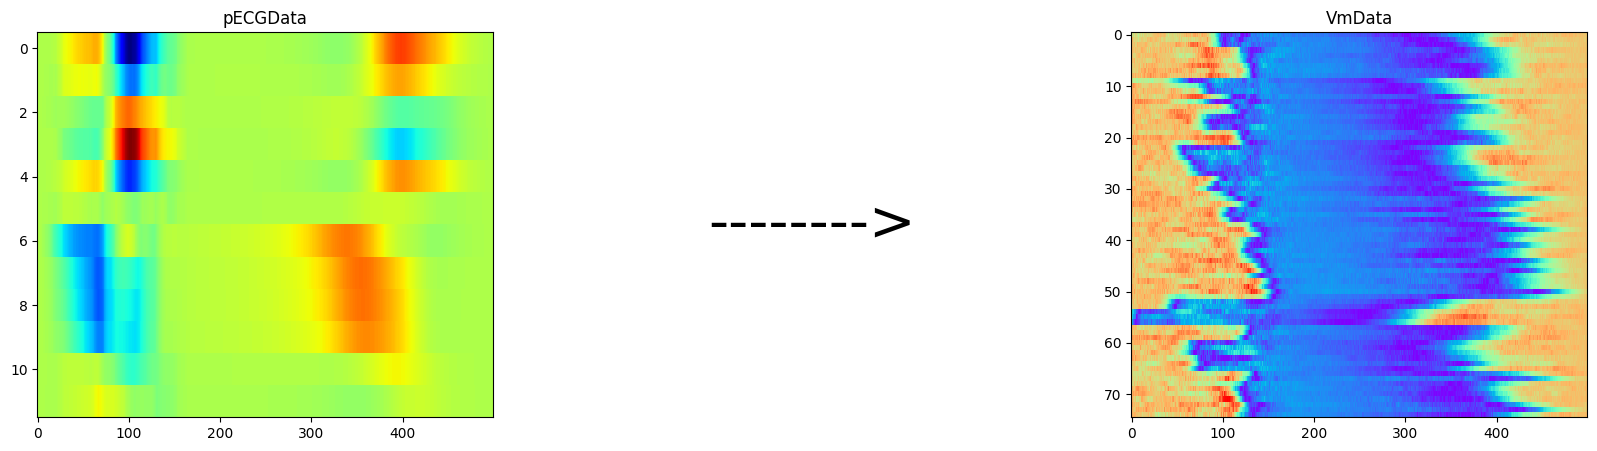

In [ ]:
# make a plot with the "pECGData" -> "ActTime"
model.eval()

data_iter = iter(valid_dataloader)

data, label = next(data_iter)
output = model(data.float().to(device))
output = output*(max_value-min_value) + min_value
label = label*(max_value-min_value) + min_value
print(label.shape, output.shape)

pECGData = data.squeeze().T
VmData1 = label.squeeze().cpu().detach().numpy().T
VmData2 = output.squeeze().cpu().detach().numpy().T
VmData = np.abs(VmData2)

# plot in row the tensors pECGData and ActTime with an arrow pointing to the activation time
row = 1
column = 3
plt.figure(figsize=(20, 5))
plt.subplot(row, column, 1)
# plot pECGData transposed
plt.imshow(pECGData.T, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('pECGData')
plt.subplot(row, column, 2)
# print a text "->"
plt.text(0.5, 0.5, '-------->', fontsize=40, horizontalalignment='center', verticalalignment='center')
plt.axis('off')
plt.subplot(row, column, 3)
# plot Vm transposed
plt.imshow(VmData.T, cmap='rainbow', interpolation='nearest', aspect='auto')
# not xticks
# plt.xticks([])
plt.title('VmData')
plt.show()
plt.close()

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(500, 75) (500, 75)


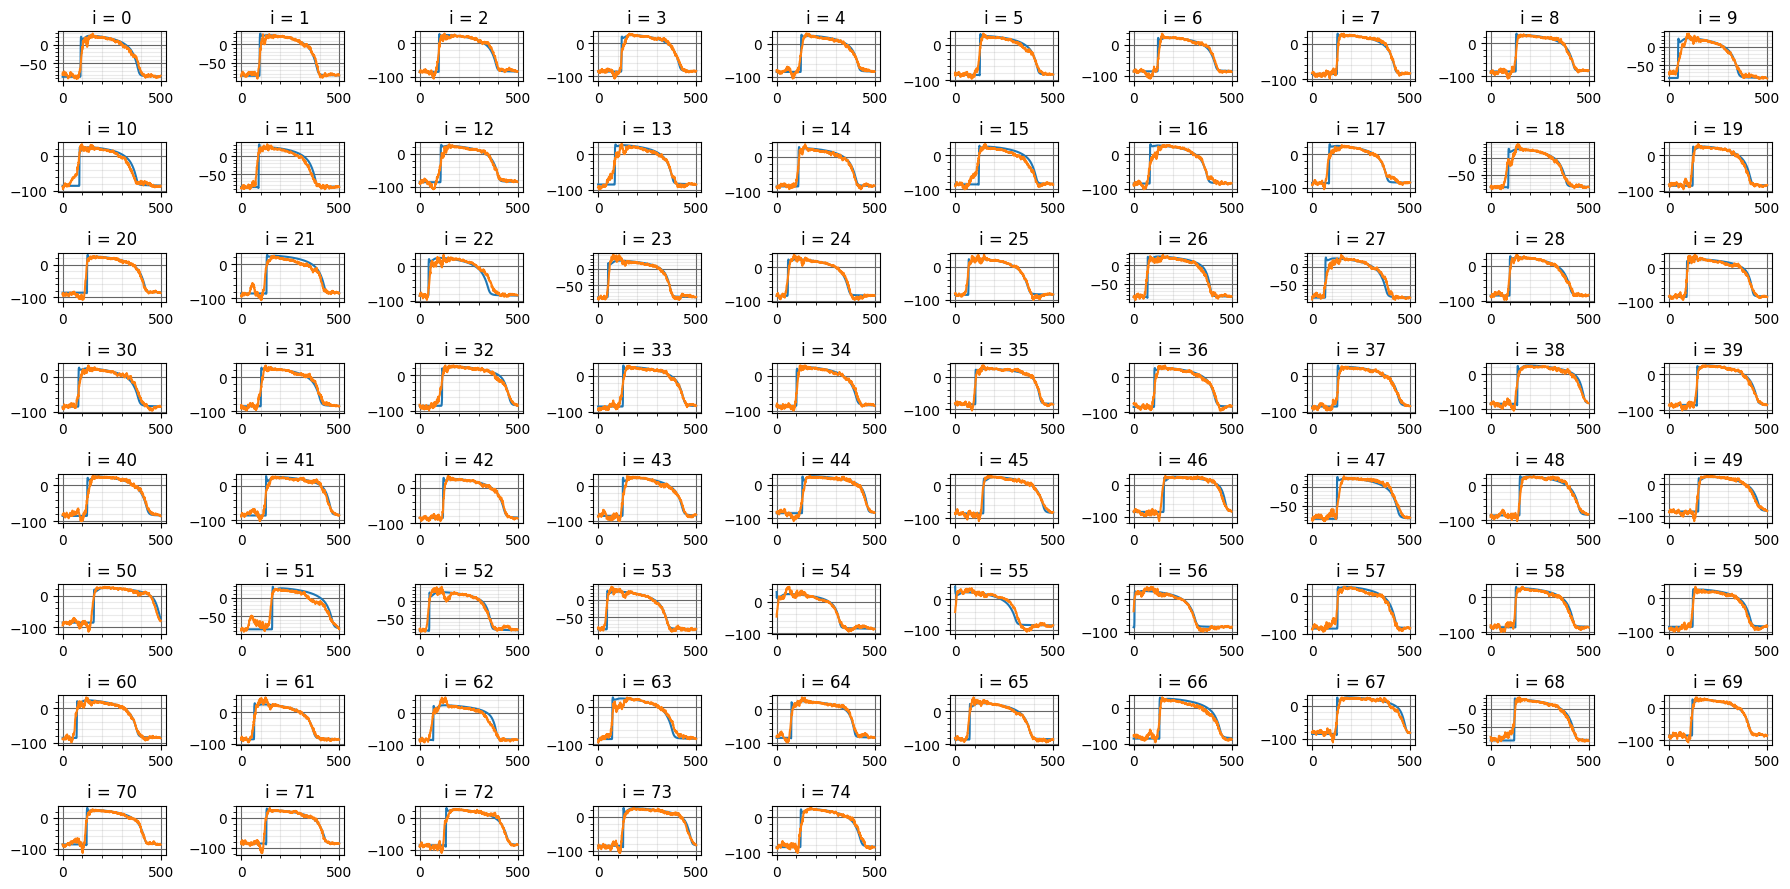

r2:  0.9571847964958933


In [ ]:
# Example of file pair
# Vm plot
row = 7
column = 10
plt.figure(figsize=(18, 9))

print(type(VmData1), type(VmData2))
print(VmData1.shape, VmData2.shape)

for count, i in enumerate(range(VmData.shape[1])):
    plt.subplot(8, 10, count + 1)
    plt.plot(VmData1[0:num_timesteps,i])
    plt.plot(VmData2[0:num_timesteps,i])
    plt.title(f'i = {i}')
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    # plt.xlabel('msec')
    # plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()
r2 = r2_score(VmData1, VmData2)
print("r2: ", r2)

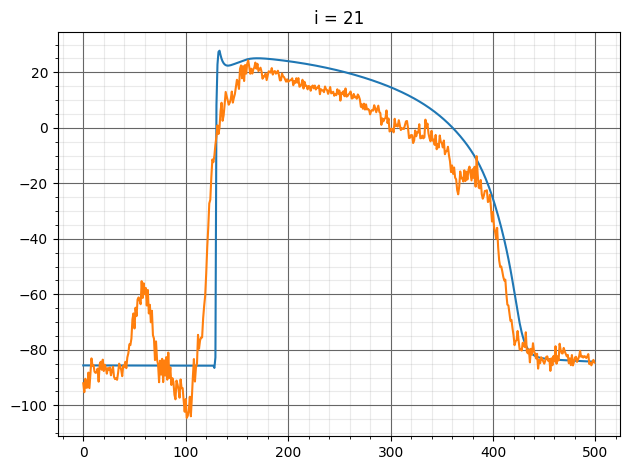

r2:  0.9571847964958933


In [ ]:
case = case + 1
# case = 0
plt.plot(VmData1[0:num_timesteps,case])
plt.plot(VmData2[0:num_timesteps,case])
plt.title(f'i = {case}')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
# plt.xlabel('msec')
# plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()
r2 = r2_score(VmData1, VmData2)
print("r2: ", r2)

In [ ]:
# Average R2 score

data_iter = iter(valid_dataloader)

r2_scores = []
for i in range(len(data_iter)):
    data, label = next(data_iter)
    output = model(data.float().to(device))
    output = output*(max_value-min_value) + min_value
    label = label*(max_value-min_value) + min_value

    VmData1 = label.squeeze().cpu().detach().numpy().T
    VmData2 = output.squeeze().cpu().detach().numpy().T

    r2_scores.append(r2_score(VmData1, VmData2))

print("mean r2 score: ", np.mean(r2_scores))

mean r2 score:  0.9732947069044181


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/LLNL/model_AE.pth")